# Qualifying Jeddah

In [1]:
import numpy as np
import fastf1
import fastf1.plotting
import pandas as pd
import matplotlib.pyplot as plt
from fastf1.core import Laps
from timple.timedelta import strftimedelta

fastf1.plotting.setup_mpl()
import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.insert(0, "../")
from settings import CACHE_FOLDER_PATH
from utlis import *

CACHE_FOLDER_PATH: C:\Users\ricca\OneDrive - ZHAW\Dokumente\f1_cache


In [3]:
setup_cache(CACHE_FOLDER_PATH)

In [4]:
session = fastf1.get_session(2024, 'Jeddah', 'Q')
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.3.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '14', '81', '4', '63', '44', '22', '18', '38', '23', '20', '3', '27', '77', '31', '10', '2', '24']


In [5]:
session.laps.split_qualifying_sessions()

[                      Time Driver DriverNumber                LapTime  \
 0   0 days 00:21:50.987000    VER            1                    NaT   
 1   0 days 00:23:19.478000    VER            1 0 days 00:01:28.491000   
 2   0 days 00:25:25.315000    VER            1 0 days 00:02:05.837000   
 3   0 days 00:29:59.456000    VER            1                    NaT   
 4   0 days 00:31:27.627000    VER            1 0 days 00:01:28.171000   
 ..                     ...    ...          ...                    ...   
 311 0 days 00:29:14.374000    SAR            2                    NaT   
 312 0 days 00:30:43.900000    SAR            2 0 days 00:01:29.526000   
 313 0 days 00:32:54.958000    SAR            2 0 days 00:02:11.058000   
 314 0 days 00:31:59.106000    ZHO           24                    NaT   
 315 0 days 00:34:00.207000    ZHO           24 0 days 00:02:01.101000   
 
      LapNumber  Stint             PitOutTime              PitInTime  \
 0          1.0    1.0 0 days 00:20:12

In [6]:
q1,q2,q3 = session.laps.split_qualifying_sessions()
q1['LapTime'] = q1['LapTime'].dt.total_seconds()
q2['LapTime'] = q2['LapTime'].dt.total_seconds()
q3['LapTime'] = q3['LapTime'].dt.total_seconds()

In [7]:
drivers = q1['Driver'].unique()

Fastest LapTime by Driver for the corresponding Qualifying session 

In [8]:

q1_times = q1.groupby('Driver')['LapTime'].min()
q2_times = q2.groupby('Driver')['LapTime'].min()
q3_times = q3.groupby('Driver')['LapTime'].min()

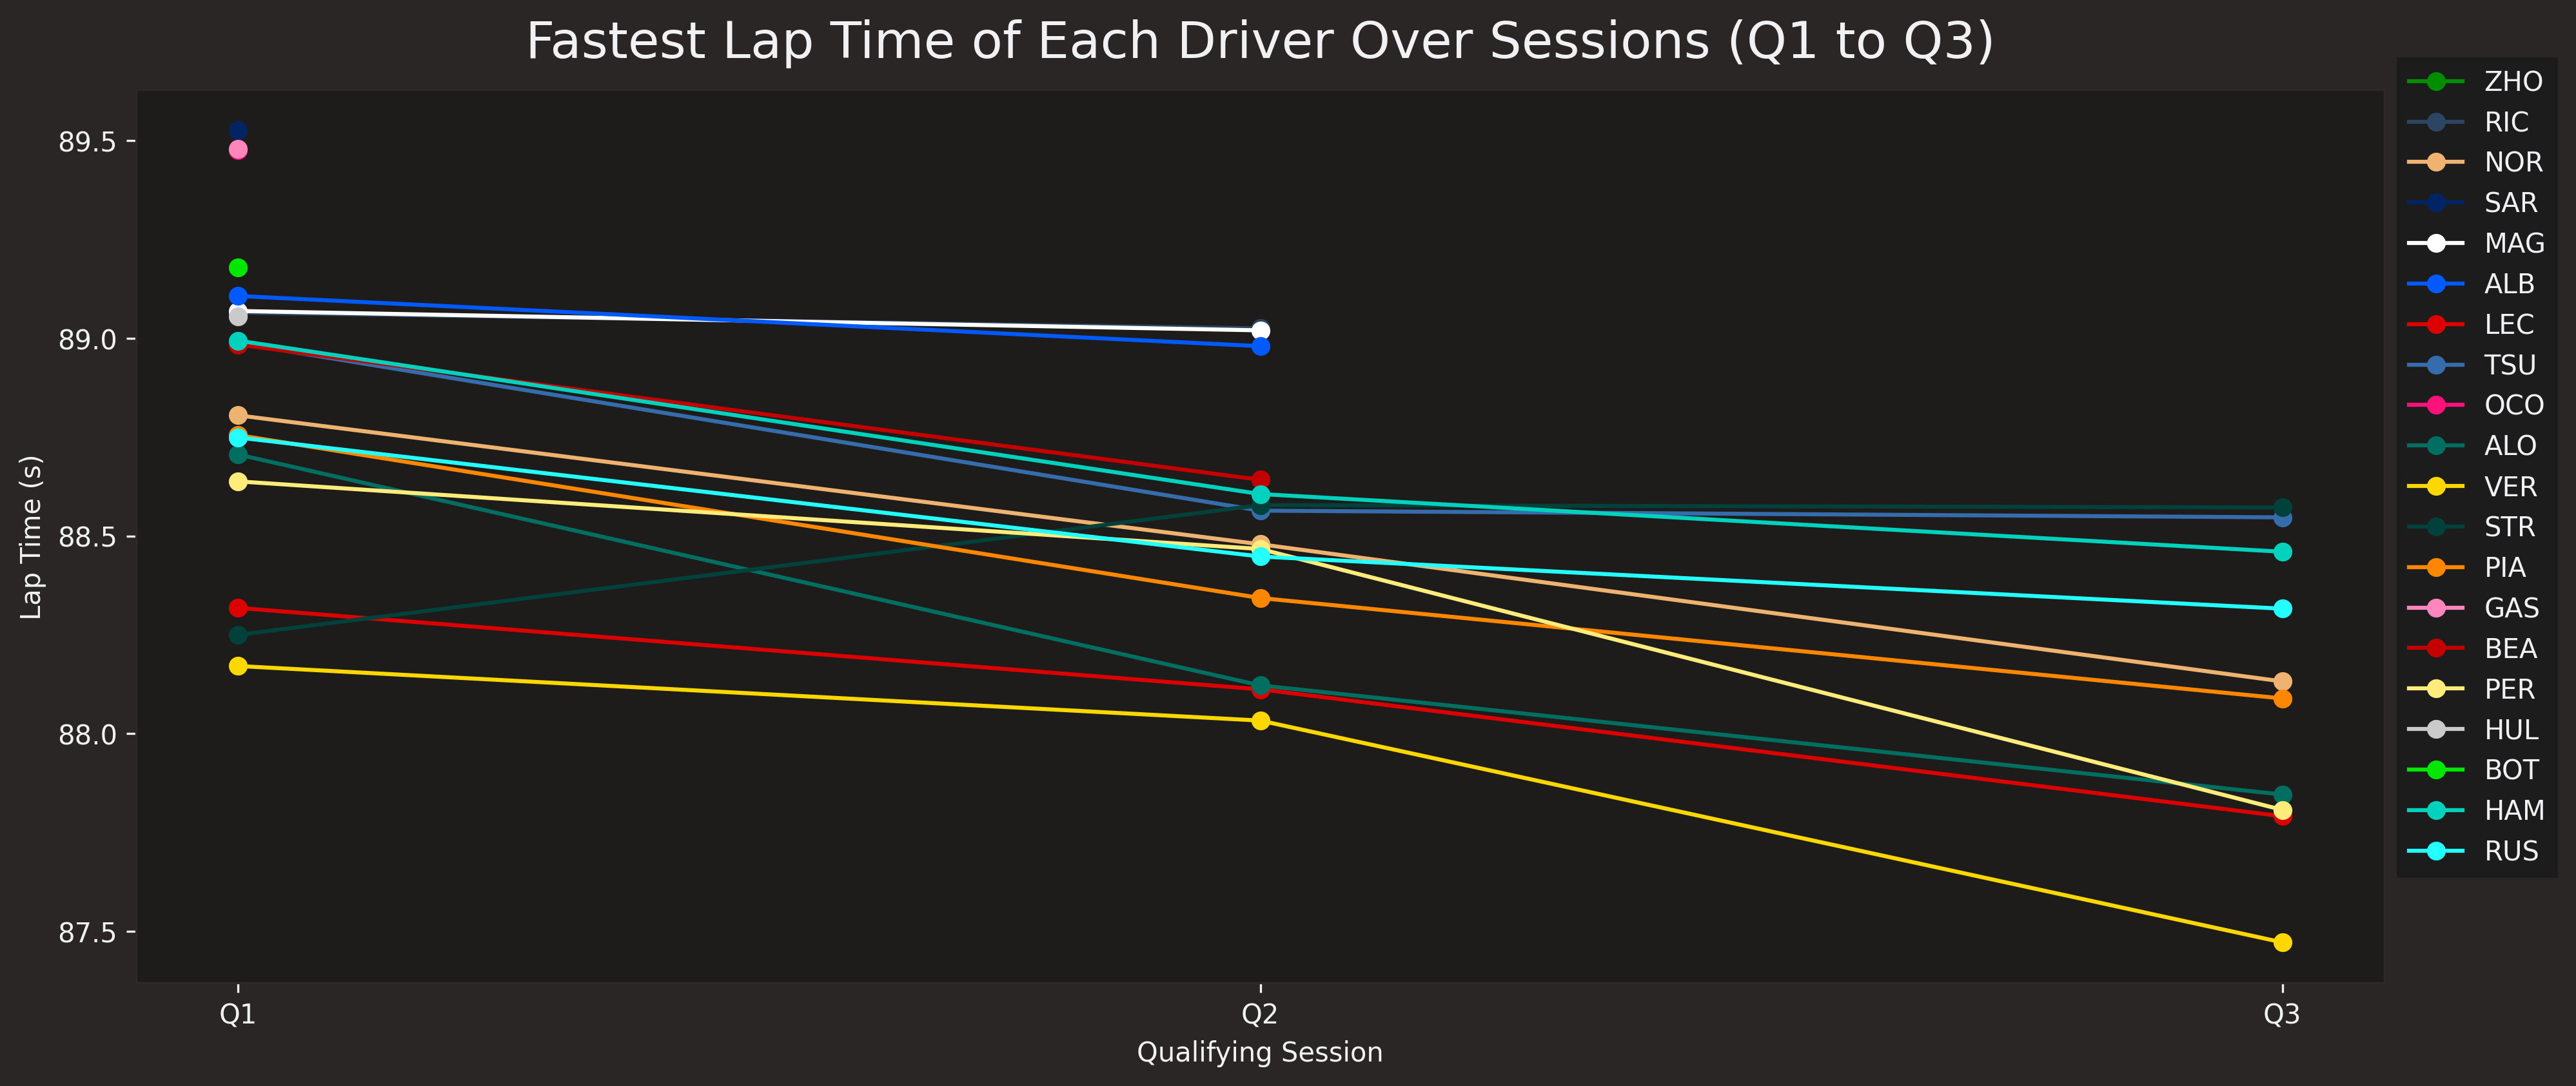

In [9]:
all_drivers = set(q1['Driver']).union(set(q2['Driver']), set(q3['Driver']))

plt.figure(figsize=(15, 6), dpi=300)

for driver in all_drivers:
    driver_lap_times = []
    driver_sessions = []

    for round , q_times in enumerate([q1, q2, q3], start=1):
        fastest_lap_time = q_times[(q_times['Driver'] == driver) & (q_times['LapTime'] <= 100)]['LapTime'].min()
        
        if fastest_lap_time is not None:
            driver_lap_times.append(fastest_lap_time)
            driver_sessions.append(round)

    if driver_lap_times:
        color = fastf1.plotting.driver_color(driver) 

        plt.plot(driver_sessions, driver_lap_times, marker='o', label=driver, color=color)

plt.xlabel('Qualifying Session')
plt.ylabel('Lap Time (s)')
plt.title('Fastest Lap Time of Each Driver Over Sessions (Q1 to Q3)')
plt.xticks([1, 2, 3], ['Q1', 'Q2', 'Q3']) 

plt.legend(loc="upper left", bbox_to_anchor=(1, 1.05))

plt.show()


In [26]:
def get_driver_ranking(session):
    return session.groupby('Driver')['Time'].min().sort_values().index.tolist()

In [34]:
sessions = [q1, q2, q3] 
all_drivers_sorted = []
for sess in sessions:
    session_ranking = get_driver_ranking(sess)
    all_drivers_sorted.extend([drv for drv in session_ranking if drv not in all_drivers_sorted])

In [39]:
driver_positions = {driver: i for i, driver in enumerate(all_drivers_sorted)}
compound_colors = fastf1.plotting.COMPOUND_COLORS

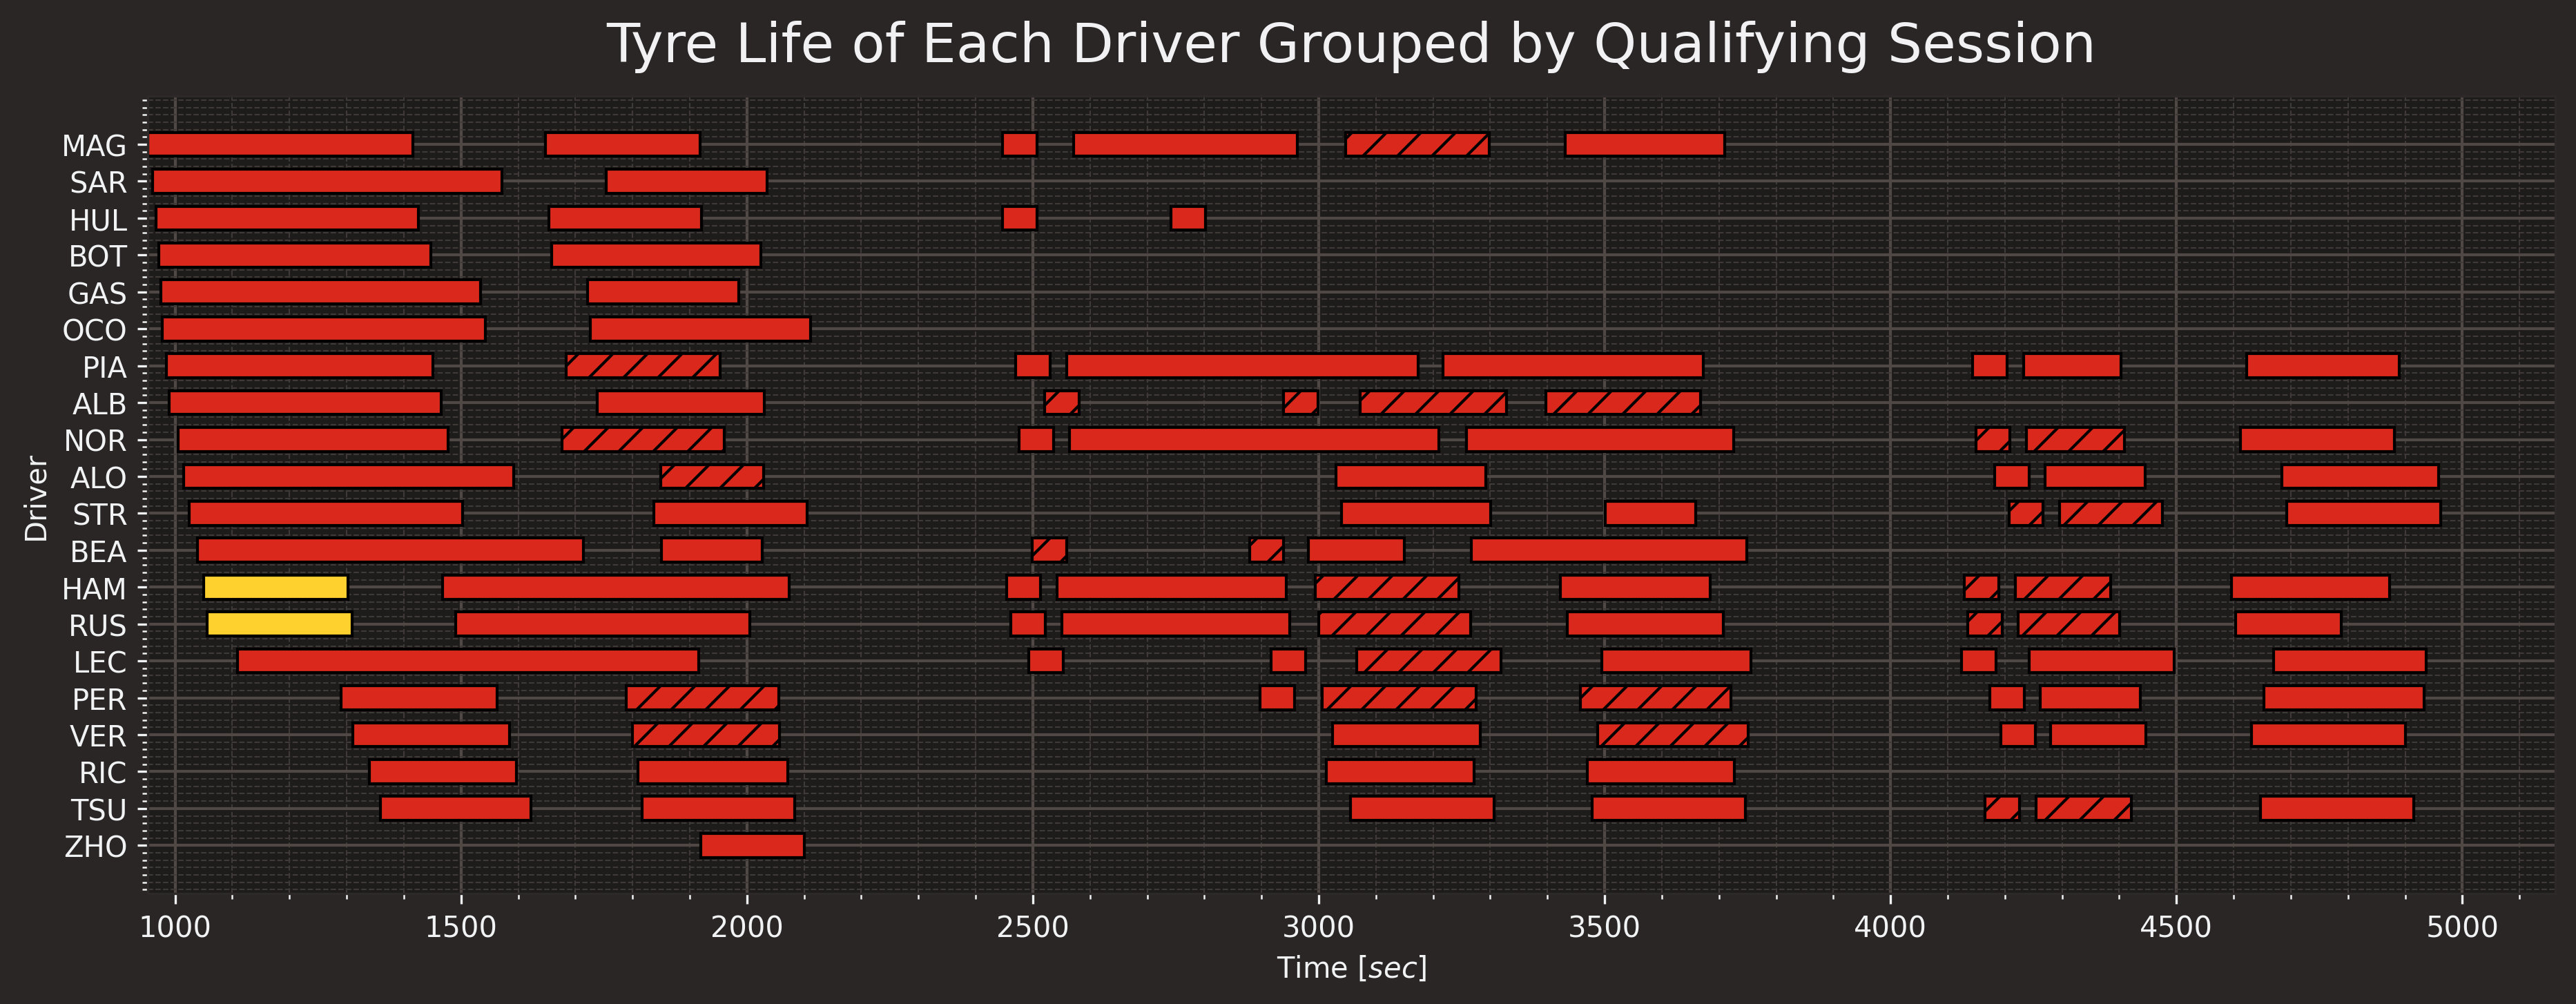

In [41]:
fig, ax = plt.subplots(figsize = (15, 5), dpi = 300 )

for sess in sessions:
    for driver in all_drivers_sorted:
        if driver in sess['Driver'].unique():
            drv_laps = sess[sess['Driver'] == driver].copy()
            drv_laps['TimeInSeconds'] = drv_laps['Time'].dt.total_seconds()
            y_position = driver_positions[driver]

            for (_, compound), group in drv_laps.groupby(['Stint', 'Compound']):
                start_time = group['TimeInSeconds'].min()
                end_time = group['TimeInSeconds'].max() + 60
                color = compound_colors.get(compound.upper(), 'black')
                
                hatch = '//' if not group['FreshTyre'].all() else None
                
                ax.barh(y_position, end_time - start_time, left=start_time, height=0.65, color=color, hatch=hatch, edgecolor='black')

ax.set_yticks(list(driver_positions.values()))
ax.set_yticklabels(all_drivers_sorted)
ax.set_xlabel('Time $[sec]$')
ax.set_ylabel('Driver')
ax.set_title('Tyre Life of Each Driver Grouped by Qualifying Session')
ax.invert_yaxis()

plt.show()
